In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
import optuna

from reinforcetrader.data_pipeline import RawDataLoader

# Reward Function Definition

We first define certain notations used in the reward functions:

$$
\large H_b = \{10, 15, 20, 25\}, \quad H_s = \{3, 5, 10\}.
$$

$$
\large
R_h^{\mathrm{ex}}(t)
= \ln\!\left(\frac{P_{t+h}}{P_t}\right)
  - \ln\!\left(\frac{B_{t+h}}{B_t}\right).
$$

$$
\large
w_{h,S,\tau}^{+}(t)
= \frac{e^{R_h^{\mathrm{ex}}(t)/\tau}}
       {\sum_{j \in S} e^{R_j^{\mathrm{ex}}(t)/\tau}},
\quad
w_{h,S,\tau}^{-}(t)
= \frac{e^{-R_h^{\mathrm{ex}}(t)/\tau}}
       {\sum_{j \in S} e^{-R_j^{\mathrm{ex}}(t)/\tau}},
\space
\mathrm{where}\space h \in S
$$

The reward functions are defined as:

$$
\large
r_{\mathrm{buy}}^{t}
= \gamma \cdot \sum_{h \in H_b} w_{h,H_b,\tau_b}^{+}(t)\, R_h^{\mathrm{ex}}(t)
  - \mathrm{cost} \cdot \bigl|\Delta \mathrm{pos}\bigr|.
$$

$$
\large
r_{\mathrm{hold\mbox{-}out}}^{t}
= \alpha \cdot \max\!\left(0,\,
  -\sum_{h \in H_s} w_{h,H_s,\tau_s}^{-}(t)\, R_h^{\mathrm{ex}}(t)\right)
  - \beta \cdot \max\!\left(0,\,
  \sum_{h \in H_b} w_{h,H_b,\tau_b}^{+}(t)\, R_h^{\mathrm{ex}}(t)\right).
$$

$$
\large
r_{\mathrm{sell}}^{t}
= \lambda \cdot \max\!\left(0,\,
  -\sum_{h \in H_s} w_{h,H_s,\tau_s}^{-}(t)\, R_h^{\mathrm{ex}}(t)\right)
  - \mathrm{cost} \cdot \bigl|\Delta \mathrm{pos}\bigr|.
$$

$$
\large
r_{\mathrm{hold\mbox{-}in}}^{t}
= \max\!\left(0,\,
  \upsilon \cdot \sum_{h \in H_b} w_{h,H_b,\tau_b}^{+}(t)\, R_h^{\mathrm{ex}}(t)
  + \mu \cdot \sum_{h \in H_s} w_{h,H_s,\tau_s}^{-}(t)\, R_h^{\mathrm{ex}}(t)\right).
$$


In [2]:
# define function to compute the weights for excess return horizons
def softmax_weights(er: pd.DataFrame, S: list[int], tau: float, positive: bool = True) -> np.ndarray:
    if tau <= 0:
        raise ValueError("tau must be > 0")
    cols = [f"{h}ER" for h in S]
    X = er[cols].to_numpy(dtype=float, copy=False)
    sign = 1.0 if positive else -1.0
    logits = (sign * X) / float(tau)
    m = np.max(logits, axis=1, keepdims=True)
    exp_shifted = np.exp(logits - m)
    W = exp_shifted / exp_shifted.sum(axis=1, keepdims=True)
    return W

# define function to compute the weighted sum of excess returns
def sum_weighted_returns(er: pd.DataFrame, S: list[int], tau: float, positive: bool = True) -> np.ndarray:
    cols = [f"{h}ER" for h in S]
    X = er[cols].to_numpy(dtype=float, copy=False)
    W = softmax_weights(er, S, tau, positive=positive)
    return (W * X).sum(axis=1)

In [3]:
def buy_reward(er: pd.DataFrame, Hb: list[int], tb, gamma: float = 1.0, cost: float = 0.005):
    return gamma * sum_weighted_returns(er, Hb, tb, positive=True) - cost

def hold_out_reward(er: pd.DataFrame, Hb, Hs: list[int], tb, ts, alpha: float = 1.0, beta: float = 1.0):
    avoid_loss = -sum_weighted_returns(er, Hs, ts, positive=False)
    miss_gain  = sum_weighted_returns(er, Hb, tb, positive=True)
    return alpha * np.maximum(0.0, avoid_loss) - beta * np.maximum(0.0, miss_gain)

def sell_reward(er: pd.DataFrame, Hs: list[int], ts, lam = 1.0, cost: float = 0.005):
    g = - lam * sum_weighted_returns(er, Hs, ts, positive=False)
    return np.maximum(0.0, g) - cost

def hold_in_reward(er: pd.DataFrame, Hb: list[int], Hs: list[int], tb, ts, upsilon: float = 1.0, mu: float = 1.0):
    g_pos = upsilon * sum_weighted_returns(er, Hb, tb, positive=True)
    g_neg = mu * sum_weighted_returns(er, Hs, ts, positive=False)
    return np.maximum(0.0, g_pos + g_neg)

In [4]:
# Helper functions used for analysis
def compute_returns(start_date, end_date, stock_ticker, index_ticker: str, horizons=list[int]) -> tuple[pd.DataFrame]:
    start = pd.to_datetime(start_date) + pd.DateOffset(days=-5)
    end = pd.to_datetime(end_date) + pd.DateOffset(days=60)
    
    # Download the data for stocks and the benchmark index
    data_loader = RawDataLoader(start_date=start, end_date=end, tickers=[stock_ticker, index_ticker], verbose=False)
    
    # Extract the close prices
    hist_prices = data_loader.get_hist_prices().xs(key='Close', level='Price', axis=1)
    
    # Compute excess returns on provided horizons
    excess_returns = pd.DataFrame(index=hist_prices.index)
    for h in horizons:
        hFR = np.log(hist_prices.shift(-h) / hist_prices)
        excess_returns[f'{h}ER'] = hFR[stock_ticker] - hFR[index_ticker]
    excess_returns.dropna(inplace=True)

    # Lastly, compute the cumulative returns
    cum_returns = (hist_prices.pct_change() + 1).cumprod().dropna()
    
    # Trim the index to the asked dates
    hist_prices = hist_prices.loc[start_date: end_date]
    cum_returns = cum_returns.loc[start_date: end_date]
    excess_returns = excess_returns.loc[start_date: end_date]
    
    return hist_prices, cum_returns, excess_returns

def compute_rewards(er: pd.DataFrame, reward_params: dict[str, object]) -> pd.DataFrame:
    # Extract reward function params
    Hb, Hs = reward_params['Hb'], reward_params['Hs']
    tb, ts = reward_params['tb'], reward_params['ts']
    cost = reward_params['cost']
    gamma = reward_params['gamma']
    alpha, beta = reward_params['alpha'], reward_params['beta']
    lam = reward_params['lambda']
    upsilon, mu = reward_params['upsilon'], reward_params['mu']
    
    Buy = buy_reward(er, Hb, tb, gamma, cost)
    HoldOut = hold_out_reward(er, Hb, Hs, tb, ts, alpha, beta)
    Sell = sell_reward(er, Hs, ts, lam, cost)
    HoldIn = hold_in_reward(er, Hb, Hs, tb, ts, upsilon, mu)

    rewards = pd.DataFrame({
        'Buy': Buy,
        'Hold-In': HoldIn,
        'Sell': Sell,
        'Hold-Out': HoldOut
    }, index=er.index)

    return rewards

In [5]:
# Define the parameters for the reward function
base_params = {'Hb': [10, 15, 20, 25], 'Hs': [3, 5, 10], 'tb': 0.5, 'ts': 0.25,'cost': 0.0005,
         'gamma': 1.0, 'alpha': 1.0, 'beta': 1.0, 'lambda': 1.0, 'upsilon': 1.0, 'mu': 1.0}

# Reward Function Optimization

In [6]:
class RewardOptimizer:
    def __init__(self, fixed_params: dict[str, object], index: str='^DJI', ):
        self.index = index
        self.fixed_params = fixed_params

        # Pre compute metrics for later use
        self._setup_study(index='^DJI')

        # Store the best params
        self._best_params = None
        
    def _setup_study(self, index: str) -> None:
        ticker_dl = RawDataLoader(start_date='1999-08-01', end_date='2019-12-09', index='DJI', verbose=False)
        self.hist_prices = ticker_dl.get_hist_prices().xs(key='Close', level='Price', axis=1)
        daily_stock_returns = np.log(self.hist_prices.shift(-1) / self.hist_prices)

        index_dl = RawDataLoader(start_date='1999-08-01', end_date='2019-12-09', tickers=[index], verbose=False)
        self.index_prices = index_dl.get_hist_prices().xs(key='Close', level='Price', axis=1)
        daily_index_returns = np.log(self.index_prices.shift(-1) / self.index_prices)

        self.daily_excess_returns = daily_stock_returns.sub(daily_index_returns[index], axis=0)
    
    def _get_trade_signals(self, params: dict[str, object])-> pd.DataFrame:
        Hb, Hs = params['Hb'], params['Hs']
        horizons = sorted(set(Hb).union(set(Hs)))

        # Precompute stock and index forward log returns once per horizon (for all tickers)
        thFR_cache = {h: np.log(self.hist_prices.shift(-h) / self.hist_prices) for h in horizons}
        ihFR_cache = {h: np.log(self.index_prices.shift(-h) / self.index_prices)[self.index] for h in horizons}

        signals = {}
        for ticker in self.hist_prices.columns:
            # Build per-ticker ER frame from cached matrices
            er = pd.DataFrame({f'{h}ER': thFR_cache[h][ticker] - ihFR_cache[h] for h in horizons}).dropna()

            # Rewards for all t at once (your vectorized compute_rewards)
            rewards = compute_rewards(er, params)

            # Compute the trade flags (i.e., either in trade or out of trade)
            out_flags = (rewards['Buy'].to_numpy() > rewards['Hold-Out'].to_numpy())
            in_flags  = (rewards['Hold-In'].to_numpy() > rewards['Sell'].to_numpy())

            # Stateful in/out scan (keeps your exact logic/order)
            state = np.empty(len(rewards), dtype=bool)
            in_trade = False
            for i in range(len(rewards)):
                if in_trade and not in_flags[i]:
                    in_trade = False
                elif not in_trade and out_flags[i]:
                    in_trade = True
                state[i] = in_trade

            signals[ticker] = pd.Series(state, index=rewards.index)

        return pd.DataFrame(signals)

    def _info_ratio_annualized(self, excess_log_returns: pd.Series) -> float: 
        mu = excess_log_returns.mean()
        std = excess_log_returns.std(ddof=1)
        return float(np.sqrt(252.0) * (mu / std))
        
    def _trade_durations(self, trade_signals: pd.DataFrame, min_length = 5) -> tuple[list[int], float]:
        trade_lengths = []
        for ticker in trade_signals.columns:
            ticker_signals = trade_signals[ticker]
            # Create group Ids for every in_trade or out_trade position
            position_groups = (ticker_signals != ticker_signals.shift()).cumsum()
            # Compute the trade length for each group Id
            ticker_trade_lengths = ticker_signals.groupby(position_groups).sum()
            # Only keep the ones for in_trade
            ticker_trade_lengths = ticker_trade_lengths[ticker_trade_lengths > 0]
            # Append to the 
            trade_lengths.extend(ticker_trade_lengths.to_list())

        # Compute the proportion of trades with duration > min_length
        min_duration_ratio = len([d for d in trade_lengths if d >= min_length]) / len(trade_lengths)
        
        return trade_lengths, min_duration_ratio
    
    def _objective(self, trial) -> float:
        reward_params = {
            **self.fixed_params,
             'tb': trial.suggest_float('tb', 1e-3, 1.0),
             'ts': trial.suggest_float('ts', 1e-3, 1.0),
             'gamma': trial.suggest_float('gamma', 1.0, 2.0),
             'alpha': trial.suggest_float('alpha', 0.0, 1.5),
             'beta': trial.suggest_float('beta', 0.0, 1.5),
             'lambda': trial.suggest_float('lambda', 1.0, 2.0),
             'upsilon': trial.suggest_float('upsilon', 0.0, 1.5),
             'mu': trial.suggest_float('mu', 0.0, 1.5)
        }

        trade_signals = self._get_trade_signals(reward_params)
        start_date, end_date = trade_signals.index[0], trade_signals.index[-1]
        daily_trade_log_returns = self.daily_excess_returns.loc[start_date: end_date][trade_signals].mean(axis=1)

        IR = self._info_ratio_annualized(daily_trade_log_returns)
        _, p_min_dur_trades = self._trade_durations(trade_signals, min_length = 5)
        target_p_min_dur_trades = 0.7
        penalty_factor = 10
        
        return IR - penalty_factor * max(0, target_p_min_dur_trades - p_min_dur_trades)
        
    def run_optimizer(self, n_trials: int = 1000) -> None:
        # Create a study object
        study = optuna.create_study(direction='maximize')
        
        # Optimize the objective function
        study.optimize(self._objective, n_trials=n_trials)

        self._best_params = study.best_params
        
    def get_opt_params(self) -> dict[str, object]:
        return self.fixed_params | self._best_params

    def get_params_performance(self, reward_params: dict, min_length: int = 5) -> dict:
        # signals & returns (bool DF aligned to returns window)
        sig = self._get_trade_signals(reward_params)
        start_date, end_date = sig.index[0], sig.index[-1]
        ret = self.daily_excess_returns.loc[start_date:end_date]
        sig = sig.reindex(ret.index).fillna(False)
    
        # equal-weight daily portfolio excess log-returns
        active = sig.sum(axis=1)
        w = sig.astype(float).div(active.where(active > 0, 1.0), axis=0)
        daily_port_excess_lr = (w * ret).sum(axis=1)
    
        # core performance
        ir = self._info_ratio_annualized(daily_port_excess_lr)
        cum_excess_ret = float(np.exp(daily_port_excess_lr.cumsum()).iloc[-1] - 1.0)
    
        # trade durations (per ticker, contiguous True runs)
        trade_lengths = []
        for c in sig.columns:
            s = sig[c].astype(int)
            g = (s != s.shift()).cumsum()
            run_first = s.groupby(g).first()
            run_len   = s.groupby(g).sum()
            trade_lengths += run_len[run_first == 1].astype(int).tolist()

        # Plot the trade lengths
        plt.hist(trade_lengths, bins=30, range=(min(trade_lengths), max(trade_lengths)))
        plt.title('Histogram of trade durations')
        plt.show()
        
        n_trades = len(trade_lengths)
        avg_len = float(np.mean(trade_lengths)) if n_trades else 0.0
        med_len = float(np.median(trade_lengths)) if n_trades else 0.0
        prop_len_ge_min = float(sum(d >= int(min_length) for d in trade_lengths) / n_trades) if n_trades else 0.0
    
        # Activity & turnover
        prop_in_trade_ticker_day = float(sig.values.mean())
        prop_days_any_position = float((active > 0).mean())
        flips_per_day = sig.astype(int).diff().abs().fillna(sig.astype(int)).sum(axis=1)
        avg_turnover_per_day = float(flips_per_day.mean())
        avg_concurrent_positions = float(active.mean())
        max_concurrent_positions = int(active.max())
    
        return {
            "start_date": start_date,
            "end_date": end_date,
            "num_days": int(len(sig)),
            "num_tickers": int(sig.shape[1]),
            "info_ratio_annualized": ir,
            "cum_excess_return": cum_excess_ret,
            "num_trades_total": n_trades,
            "avg_trade_length": avg_len,
            "median_trade_length": med_len,
            f"prop_trades_len>={min_length}": prop_len_ge_min,
            "prop_in_trade_ticker_day": prop_in_trade_ticker_day,
            "prop_days_any_position": prop_days_any_position,
            "avg_turnover_per_day": avg_turnover_per_day,
            "avg_concurrent_positions": avg_concurrent_positions,
            "max_concurrent_positions": max_concurrent_positions,
        }


In [7]:
fixed_params = {'Hb': [10, 15, 20, 25], 'Hs': [3, 5, 10], 'cost': 0.0005}
optimizer = RewardOptimizer(fixed_params=fixed_params)
# Run the optimizer
optimizer.run_optimizer(n_trials=10000)

[I 2025-09-05 13:00:42,734] A new study created in memory with name: no-name-3096918e-f283-460f-8429-76e20e7b7dd4
[I 2025-09-05 13:00:43,263] Trial 0 finished with value: 9.723021009446157 and parameters: {'tb': 0.6348003197186323, 'ts': 0.41965833951114734, 'gamma': 1.1716698705294757, 'alpha': 0.8259201195331648, 'beta': 0.9936649076046359, 'lambda': 1.8449098014986098, 'upsilon': 0.7920334102497538, 'mu': 0.5526431696242238}. Best is trial 0 with value: 9.723021009446157.
[I 2025-09-05 13:00:43,707] Trial 1 finished with value: 9.726611091093558 and parameters: {'tb': 0.9317762007112137, 'ts': 0.5281692370643238, 'gamma': 1.777278380681791, 'alpha': 1.3952538405342276, 'beta': 1.3659808741903778, 'lambda': 1.9450774628813061, 'upsilon': 0.37692949493902644, 'mu': 0.27427749101257365}. Best is trial 1 with value: 9.726611091093558.
[I 2025-09-05 13:00:44,221] Trial 2 finished with value: 9.470473575803927 and parameters: {'tb': 0.8705520932461469, 'ts': 0.4004494247061671, 'gamma': 1

{'Hb': [10, 15, 20, 25],
 'Hs': [3, 5, 10],
 'alpha': 1.4994311232655035,
 'beta': 2.6728660684012442e-05,
 'cost': 0.0005,
 'gamma': 1.0001611784206483,
 'lambda': 1.000151599870553,
 'mu': 0.025944468304562228,
 'tb': 0.76424780686834,
 'ts': 0.9162880224476919,
 'upsilon': 1.0836268237566462}


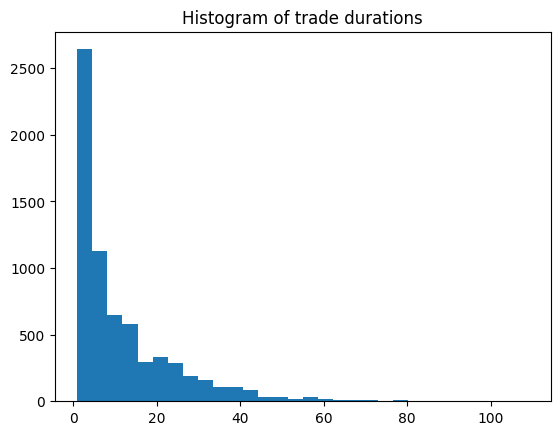

{'avg_concurrent_positions': 15.266038846380223,
 'avg_trade_length': 11.560095082454316,
 'avg_turnover_per_day': 2.638610947616245,
 'cum_excess_return': 711105739.8048753,
 'end_date': Timestamp('2019-10-31 00:00:00'),
 'info_ratio_annualized': 12.219614992658688,
 'max_concurrent_positions': 23,
 'median_trade_length': 7.0,
 'num_days': 5097,
 'num_tickers': 28,
 'num_trades_total': 6731,
 'prop_days_any_position': 1.0,
 'prop_in_trade_ticker_day': 0.545215673085008,
 'prop_trades_len>=5': 0.6074877432773733,
 'start_date': Timestamp('1999-08-02 00:00:00')}


In [8]:
# Display the optimal parameters
opt_reward_params = optimizer.get_opt_params()
pprint.pprint(opt_reward_params)

# Display the optimal parameters performance metrics
pprint.pprint(optimizer.get_params_performance(opt_reward_params))